    Ben Christensen
    Math 436
    December 17, 2018

# Predicting Stock Prices with the Euler-Maruyama Method

One way to model the fluctutation in stock prices is with one-dimensional Brownian motion. This differential equation translates to a method for predicting future stock prices. My implementation follows the analytical approximation methods found in Timothy Sauer's "Numerical Solution of Stochastic Differential Equations in Finance" found here: http://math.gmu.edu/~tsauer/pre/sde.pdf

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats.mstats import mquantiles
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In the file "ACME_Inc_historic_data2.txt" are the stock prices for a fictitious company named ACME Inc. for three years, ending December 15, 2018. 

In [2]:
data = np.loadtxt("ACME_Inc_historic_data2.txt", delimiter=',')

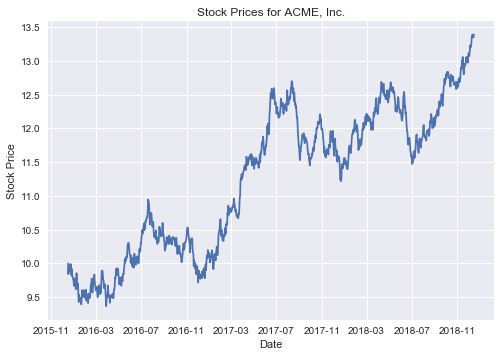

In [3]:
dates = pd.date_range(end=pd.datetime(2018, 12, 15), periods=365*3)
plt.plot(dates, data[:,1])
plt.title("Stock Prices for ACME, Inc.")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.show()

The differential equation model for stock prices that includes brownian motion is as follows:

$$ \frac{dS}{S} = \mu dt + \sigma dW $$
or
$$ dS  = \mu S dt + \sigma S dW $$

Brownian motion is represented by $dW$. Given $z_i \sim \mathcal{N}(0,1)$, 

$$dW = z_i\sqrt{dt} = z_i$$

In this application, $dt=1$ because the increment of time is 1 day. 
So, the model can be simplified to 

$$ dS  = \mu S + \sigma S z_i $$

Now, we can use numerical methods to predict future stock prices if we can find $\mu$ and $\sigma$.

We approximate $S_i$ with $w_i$. Now for $w_0, w_1, ..., w_n$, 

$$ w_{i+1} - w_i = \mu w_i + \sigma w_i z_i $$



Define the return at period $i$ to be  $$r_i = \frac{w_{i+1} - w_i}{w_i}$$
Now, 
$$ r_i = \mu dt + \sigma dW $$ 

Following Sauer's methods, we approximate $\mu$ and $\sigma$ as the mean and standard error of the returns over the past three years. Since there are $n$ data-points, there are $n-1$ returns.

$$\mu = \frac{1}{n-1} \sum_{i=1}^{n} r_i $$

$$\sigma = \sqrt{\frac{1}{n-2} \sum_{i=1}^{n} (r_i - \mu)^2}$$

These formulas fit with how we intuitively might expect them to look. Ignoring $\sigma$ in our differential equation, 

$$ w_{i+1} - w_i \approx \mu w_i $$

So, $$r_i \approx \mu $$

Also, $$ w_{i+1} - w_i  - \mu w_i= \sigma w_i z_i $$
So, $$ r_i - \mu \approx \sigma z_i $$

Now we apply these numerical methods to estiamte $\mu$ and $\sigma$ using the three years of stock values for ACME, Inc.

In [4]:
#Calculate daily returns for data given
returns = (data[1:,1] - data[:-1,1])/data[:-1,1]
#Approximate mu using average returns
mu = np.mean(returns)
#Approximate standard deviation of the returns 
n = len(returns)
sigma = np.sqrt((1/(n-1))*np.sum((returns - mu)**2))
print(mu, sigma)

0.000287494466666 0.00640537644224


$$\mu=0.000287$$
$$\sigma=0.006405$$

Now beginning with $w_0$ as the last stock price in the dataset, December 15, 2018, we approximate each following stock price until December 31, 2019 using, the values for $\mu$ and $\sigma$ that we calculated

$$w_{i+1} = 0.000287 w_i dt + 0.006405w_i z_i + w_i$$

The approximate value of $w_{381}$ is the approximate stock price on December 31, 2019.

In [5]:
#Define an approximation for the next stock price
#   using the Euler-Maruyama Method
approx_w = lambda w: w + w*mu + w*sigma*np.random.normal(0,1)
#Approximate the stock price on December 31, 2019 10,000 times to find 
#    a probability distribution for the approximate stock on that day
solutions = []
for i in range(10000):
    #Start with the stock price on the last day in the dataset
    w = data[-1,1]
    solution = list()
    for i in range(381):
        #Approximate the next day's stock price
        w = approx_w(w)
        solution.append(w)
        #print(w)
    #Each solution contains every day's approximation until Dec 31, 2019
    solutions.append(solution)
    #The final w is the approximation for Dec 31, 2019
    final_approx = [solution[-1] for solution in solutions]
solutions = np.array(solutions)

Since $z_i$ is drawn from $\mathcal{N}(0,1)$, each time we approximate $w_{381}$ we will get a different answer. After approximating it 10,000 times, we plot the probability distribution:

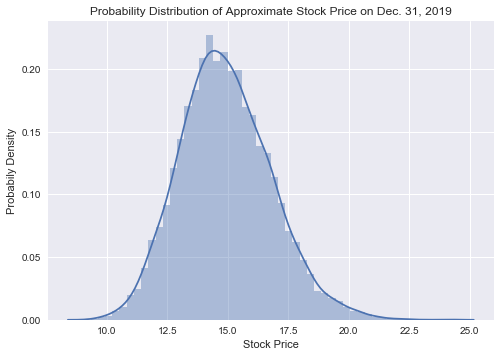

In [6]:
sns.distplot(final_approx)
plt.xlabel("Stock Price")
plt.ylabel("Probabily Density")
plt.title("Probability Distribution of Approximate Stock Price on Dec. 31, 2019")
plt.show()

Following the same steps we can, starting with the first day in the dataset, approximate the subsequent days for three years using our model. This way we can see how the model fits the data. Then, taking the average prediction for each $w_i$, we can find a 95% confidence interval for the average prediction of $w_i$. This is implemented and plotted below.

In [7]:
#Now apply our model to the previous three years 
#    (see how well our model fits the data we have)
means = list()
for j in range(200):
    solutions = list()
    for k in range(200):
        #Start with the stock price on the last day in the dataset
        w = data[0,1]
        solution = list()
        for i in range(365*3):
            #Approximate the next day's stock price
            w = approx_w(w)
            solution.append(w)
            #print(w)
        #Each solution contains every day's approximation until Dec 31, 2019
        solutions.append(solution)
        #The final w is the approximation for Dec 31, 2019
        final_approx = [solution[-1] for solution in solutions]
    solutions = np.array(solutions)
    means.append(np.mean(solutions, axis=0))
means = np.array(means)

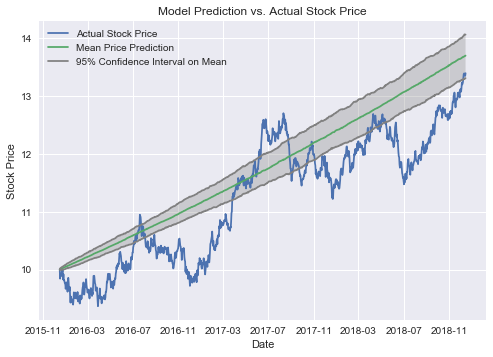

In [8]:
#Plot the success of our distribution
lower, mean, upper = mquantiles(means, [.025, .5, .975], axis=0)
plt.plot(dates, data[:,1], label="Actual Stock Price")
plt.plot(dates, mean, label="Mean Price Prediction")
plt.plot(dates, lower, color='gray', label="95% Confidence Interval on Mean")
plt.plot(dates, upper, color='gray')
plt.fill_between(dates, upper, lower, where=upper>=lower, facecolor='gray', alpha=.3)
plt.legend()
plt.title("Model Prediction vs. Actual Stock Price")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.show()

The model on average (mean not median) predicts a stock value higher than the actual value of the stock on December 15, 2018, but it is still within \$0.50 of the true value. If we believe the stock value for ACME, Inc. will continue this pattern of growth, we may trust our model to give a reasonable approximation for what the value will be in the next few years.